In [1]:
import xarray as xr
import numpy as np
import os

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

## Runtime

[17.11.22] On a single node, single process:

### CFFI
---------

* total runtime: 488 s
* max runtime for warmrain: 390 seconds
* avg                     : 0.00048 seconds

### Fortran
------

* total runtime: 159 s
* max runtime for warmrain: 0.861 seconds
* avg                     : 0.00003 seconds

## Setup

In [3]:
def get_value(bridge='fortran', file='atm_2d', value='qrvi', cold=False):
    
    ds = get_ds(bridge=bridge, file=file, cold=cold)
    
    return ds[value]

In [4]:
def get_ds(bridge='fortran', file='atm_2d', cold=False):
    if cold:
        c = '_cold_'
    else:
        c = '_'
        
    expdir = f'/work/ka1176/caroline/gitlab/icon-aes/experiments/aes_bubble_2mom{c}{bridge}/'    
        
    ds = xr.open_dataset(os.path.join(expdir, f'aes_bubble_2mom{c}{bridge}_{file}_ml_20080801T000000Z.nc'))
    ds.close()
    
    time_mins = (ds.time - ds.time[0])*24*60 # min
    ds['time'] = time_mins
    
    return ds

In [5]:
def comparison_plot_2D(file='atm_2d', value='qrvi', cold=False):
    c = get_value(bridge='cffi', value=value, cold=cold)
    f = get_value(bridge='fortran', value=value, cold=cold)    
    
    long_name = c.attrs['long_name']
    units = c.attrs['units']
    
    lbl = f'{value} ({units})'
    
    vmin = min(c.min(), f.min())
    vmax = max(c.max(), f.max())
    
    # left right bottom top
    extent = [c.time.min(), c.time.max(), c.ncells.min(), c.ncells.max()]
    
    sns.set_style('white')
    
    fig, ax = plt.subplots(1, 4, sharex=True, figsize=(18, 4))
    
    # Fortran    
    img=ax[0].imshow(f.T, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=extent)
    plt.colorbar(img, ax=ax[0], label=lbl)
    ax[0].set_title('Bubble (Fortran)')
    ax[0].set_ylabel('Grid cells')
    
    # CFFI
    img=ax[1].imshow(c.T, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=extent)
    plt.colorbar(img, ax=ax[1], label=lbl)
    ax[1].set_title('Bubble (ML via CFFI)')
    ax[1].set_ylabel('Grid cells')
    
    # Difference
    cf = c - f
    mav = np.max(np.abs(cf))
    img=ax[2].imshow(cf.T, aspect='auto', cmap='RdBu', vmin=-mav, vmax=+mav, extent=extent)
    plt.colorbar(img, ax=ax[2], label=lbl)
    ax[2].set_title('Difference (ML - Fortran)')
    ax[2].set_ylabel('Grid cells')
    
    # 1D Time evolution
    sf = f.mean(axis=1)
    sc = c.mean(axis=1)
        
    ax[3].plot(f.time, sf, label='Fortran', color='C0', lw=2)
    ax[3].plot(c.time, sc, label='ML via CFFI', color='C3', lw=2)
    
    ax[3].legend()
    ax[3].set_ylabel(lbl)
    ax[3].set_title('Grid cell average')
    
    
    
    [axx.set_xlabel('Time (mins)') for axx in ax]
    
    #fig.text(0.5, 1, lbl, ha='center', va='top', fontsize='large')
    
    print(f'Value: {value}')
    print(f'Long name: {long_name}')
    print(f'Units: {units}')
    print()
    
    fig.tight_layout()

## Atmosphere 2D variables

In [6]:
ds = get_ds(bridge='cffi')
ds

<xarray.Dataset>
Dimensions:    (time: 241, ncells: 880, vertices: 3)
Coordinates:
  * time       (time) float64 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    clon       (ncells) float32 ...
    clat       (ncells) float32 ...
Dimensions without coordinates: ncells, vertices
Data variables: (12/22)
    clon_bnds  (ncells, vertices) float32 ...
    clat_bnds  (ncells, vertices) float32 ...
    ps         (time, ncells) float64 ...
    psl        (time, ncells) float64 ...
    ts         (time, ncells) float64 ...
    clt        (time, ncells) float64 ...
    ...         ...
    prls       (time, ncells) float64 ...
    cptgzvi    (time, ncells) float64 ...
    pr_rain    (time, ncells) float64 ...
    pr_snow    (time, ncells) float64 ...
    pr_grpl    (time, ncells) float64 ...
    pr_ice     (time, ncells) float64 ...
Attributes:
    CDI:                  Climate Data Interface version 1.8.4 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          f978b88c-3677-11e9-b648-1fcceafacc15
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               @
    history:              /home/k/k202141/rootgit/icon-aes/bin/icon at 202211...
    references:           see MPIM/DWD publications
    comment:              Caroline Arnold (k202141) on l30302 (Linux 4.18.0-3...

Value: qrvi
Long name: vertically integrated rain
Units: kg m-2

Value: clivi
Long name: vertically integrated cloud ice
Units: kg m-2

Value: qsvi
Long name: vertically integrated snow
Units: kg m-2



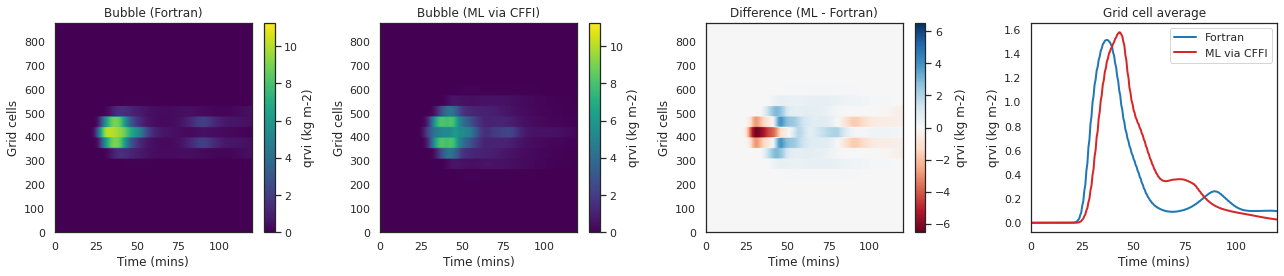

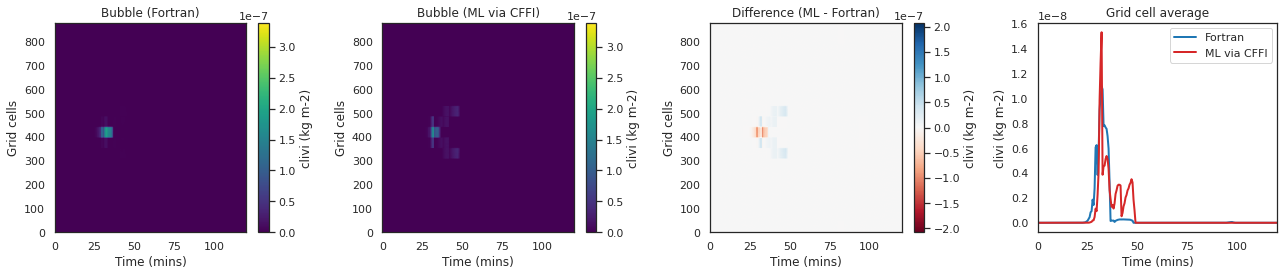

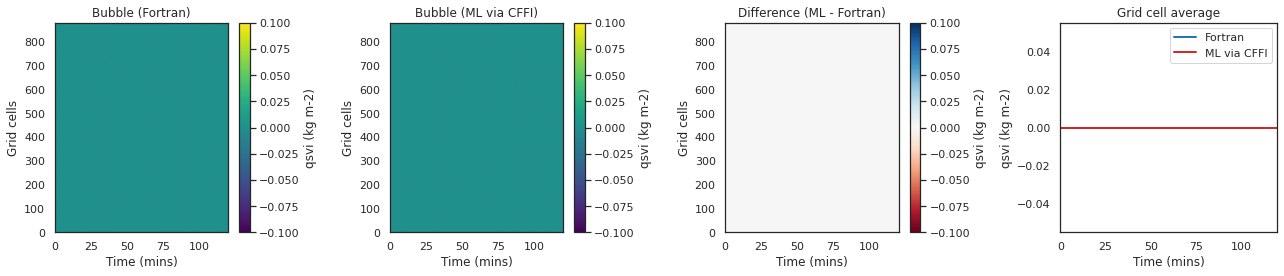

In [7]:
atm_2d_vi = ['qrvi', 'clivi', 'qsvi']

for value in atm_2d_vi:

    comparison_plot_2D(value=value, cold=False)

Value: pr_rain
Long name: stratiform rainfall flux (cloud_two output)
Units: kg/m2/s

Value: pr_snow
Long name: stratiform snowfall flux (cloud_two output)
Units: kg/m2/s

Value: pr_grpl
Long name: stratiform graupel flux (cloud_two output)
Units: kg/m2/s

Value: pr_ice
Long name: stratiform icefall flux (cloud_two output)
Units: kg/m2/s



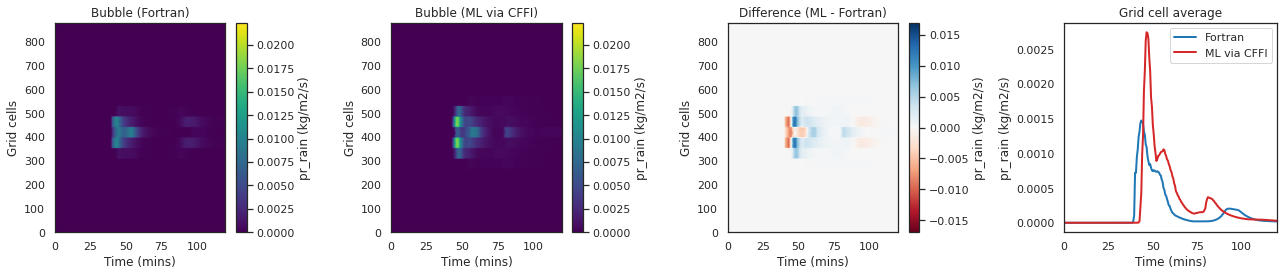

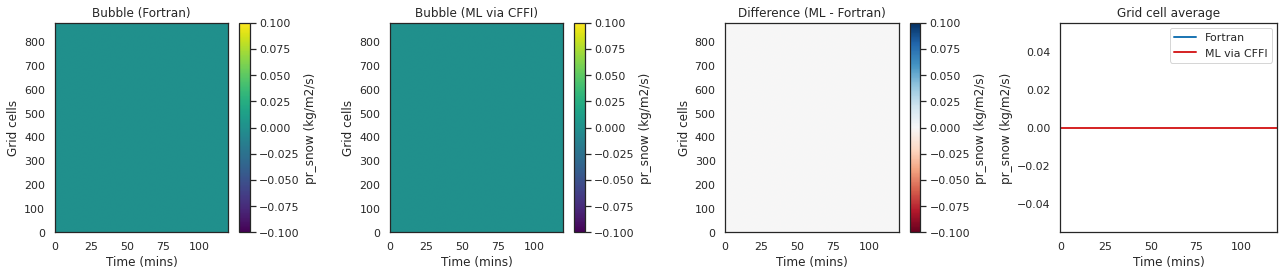

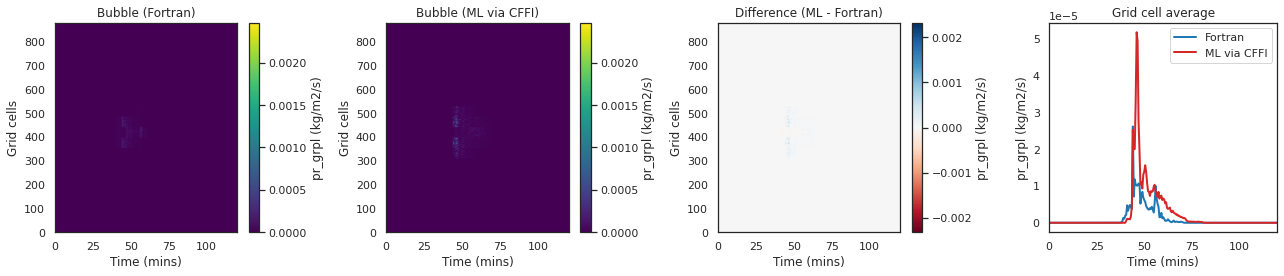

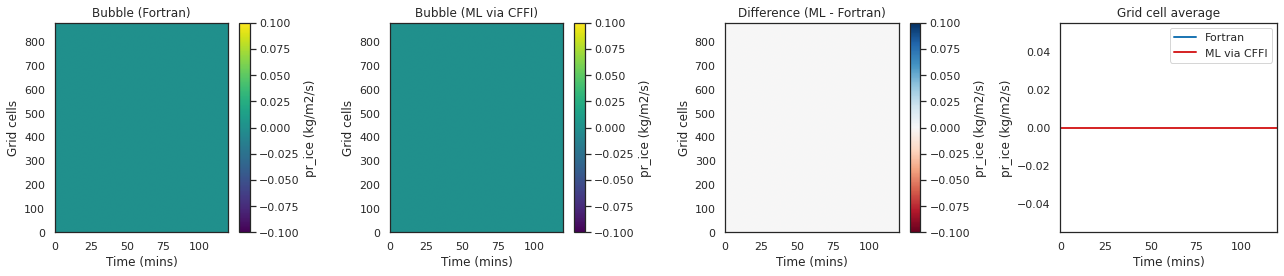

In [8]:
atm_2d_flux = ['pr_rain', 'pr_snow', 'pr_grpl', 'pr_ice']

for value in atm_2d_flux:

    comparison_plot_2D(value=value, cold=False)

## Atmosphere 3D variables

In [9]:
ds = get_ds(bridge='fortran', file='atm_3d')
ds

<xarray.Dataset>
Dimensions:      (time: 241, ncells: 880, vertices: 3, height: 70, bnds: 2, height_2: 71)
Coordinates:
  * time         (time) float64 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    clon         (ncells) float32 ...
    clat         (ncells) float32 ...
  * height       (height) float64 1.0 2.0 3.0 4.0 5.0 ... 67.0 68.0 69.0 70.0
  * height_2     (height_2) float64 1.0 2.0 3.0 4.0 5.0 ... 68.0 69.0 70.0 71.0
Dimensions without coordinates: ncells, vertices, bnds
Data variables: (12/26)
    clon_bnds    (ncells, vertices) float32 ...
    clat_bnds    (ncells, vertices) float32 ...
    height_bnds  (height, bnds) float64 ...
    ps           (time, ncells) float64 ...
    pfull        (time, height, ncells) float64 ...
    zg           (height, ncells) float64 ...
    ...           ...
    qnr          (time, height, ncells) float64 ...
    qns          (time, height, ncells) float64 ...
    qng          (time, height, ncells) float64 ...
    qnh          (time, height, ncells) float64 ...
    qnc          (time, height, ncells) float64 ...
    ninact       (time, height, ncells) float64 ...
Attributes:
    CDI:                  Climate Data Interface version 1.8.4 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          f978b88c-3677-11e9-b648-1fcceafacc15
    uuidOfVGrid:          36987ca3-08bc-7f9a-a506-45859f4c1ca0
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               @
    history:              /home/k/k202141/rootgit/icon-aes/bin/icon at 202211...
    references:           see MPIM/DWD publications
    comment:              Caroline Arnold (k202141) on l10100 (Linux 4.18.0-3...

### Moments

In [10]:
def plot_height_profile(hydrometeors=['cloud', 'rain'], cold=False, moment='specific_content'):
    
    if moment == 'specific_content':
        mom = ['clw', 'qr', 'cli', 'qs', 'qg', 'qh']
        clbl = 'specific content (kg/kg)'
        cmap = 'Blues'
    elif moment == 'number_concentration':
        mom = ['qnc', 'qnr', 'qni', 'qns', 'qng', 'qnh']
        clbl = 'number concentration (1/kg)'
        cmap = 'Oranges'
    else:
        raise ValueError
    
    if isinstance(hydrometeors, str):
        hydrometeors = [hydrometeors]
    
    # global settings
    all_hydrometeors = ['cloud', 'rain', 'ice', 'snow', 'graupel', 'hail']
    
    fds = get_ds(bridge='fortran', file='atm_3d', cold=cold)
    cds = get_ds(bridge='cffi', file='atm_3d', cold=cold)
    
    # figure setup
    nrows = len(hydrometeors)
    sns.set_style('white')
    fig, ax = plt.subplots(nrows, 3, figsize=(18, nrows*4))
    ax = ax.reshape(nrows, -1)
    
    # left right bottom top
    zg = fds['zg']
    extent = [fds.time.min(), fds.time.max(), fds.zg.min(), fds.zg.max()]
    
    cmap2 = 'PRGn'
    
    for i, hmet in enumerate(hydrometeors):
        j = all_hydrometeors.index(hmet)
        
        # values
        fv = fds[mom[j]]
        fvv = fv.sum(axis=2)
        cv = cds[mom[j]]
        cvv = cv.sum(axis=2)
        
        vmin = min(fvv.min(), cvv.min())
        vmax = max(fvv.max(), cvv.max())
        
        # Fortran moment 1
        img=ax[i,0].imshow(fvv.T, aspect='auto', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar(img, label=clbl, ax=ax[i,0])
        ax[i,0].set_title(f'{hmet} (Fortran)')
        
        # CFFI moment 1
        img=ax[i,1].imshow(cvv.T, aspect='auto', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar(img, label=clbl, ax=ax[i,1])
        ax[i,1].set_title(f'{hmet} (ML via CFFI)')
        
        # Diff
        diff = (cv - fv).sum(axis=2)
        mav = np.max(np.abs(diff))
        img=ax[i,2].imshow(diff.T, aspect='auto', extent=extent, vmin=-mav, vmax=+mav, cmap=cmap2)
        plt.colorbar(img, label=clbl, ax=ax[i,2])
        ax[i,2].set_title(f'{hmet} difference (ML - Fortran)')
        
    
    [axx.set_xlabel('Time (mins)') for axx in ax.flatten()]
    [axx.set_ylabel('Geometric height (m)') for axx in ax.flatten()]
        
    fig.tight_layout()

In [11]:
def plot_vertical_profile(values, cold=False):
    
    fds = get_ds(bridge='fortran', file='atm_3d', cold=cold)
    cds = get_ds(bridge='cffi', file='atm_3d', cold=cold)
    
    # figure setup
    nrows = len(values)
    ncols = 4
    sns.set_style('white')
    fig, ax = plt.subplots(nrows, ncols, figsize=(18, nrows*4))
    ax = ax.reshape(nrows, -1)
    
    # left right bottom top
    zg = fds['zg']
    extent = [fds.time.min(), fds.time.max(), fds.zg.min(), fds.zg.max()]
    
    cmap = 'Blues'
    cmap2 = 'PRGn'
        
    for i, value in enumerate(values):        
        # values
        fv = fds[value]
        fvv = fv.mean(axis=2)
        cv = cds[value]
        cvv = cv.mean(axis=2)
        
        vmin = min(fvv.min(), cvv.min())
        vmax = max(fvv.max(), cvv.max())
        
        long_name = fv.attrs['long_name']
        units = fv.attrs['units']
    
        clbl = f'{long_name} ({units})'
        
        # Fortran
        img=ax[i,0].imshow(fvv.T, aspect='auto', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar(img, label=clbl, ax=ax[i,0])
        ax[i,0].set_title(f'{long_name} (Fortran)')
        
        # CFFI
        img=ax[i,1].imshow(cvv.T, aspect='auto', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar(img, label=clbl, ax=ax[i,1])
        ax[i,1].set_title(f'{long_name} (ML via CFFI)')
        
        # Diff
        diff = (cv - fv).mean(axis=2)
        mav = np.max(np.abs(diff))
        img=ax[i,2].imshow(diff.T, aspect='auto', extent=extent, vmin=-mav, vmax=+mav, cmap=cmap2)
        plt.colorbar(img, label=clbl, ax=ax[i,2])
        ax[i,2].set_title(f'{long_name} difference (ML - Fortran)')
        
                
        # Time step
        t_ix = 80
        
        ax[i,3].plot(fvv[t_ix].values, zg.mean(axis=-1), lw=2, color='C2', label=f'Fortran {fvv[t_ix].time.values:.0f} min')
        ax[i,3].plot(cvv[t_ix].values, zg.mean(axis=-1), lw=2, color='C3', label=f'ML {cvv[t_ix].time.values:.0f} min')
        ax[i,3].set_xlabel(clbl)        
        ax[i,3].legend()
        
    [axx.set_xlabel('Time (mins)') for axx in ax[:,:3].flatten()]
    [axx.set_ylabel('Geometric height (m)') for axx in ax.flatten()]
    [axx.set_ylim(0, 7000) for axx in ax.flatten()]
                        
    fig.tight_layout()

In [12]:
def plot_temporal_profile(values, cold=False):
    
    fds = get_ds(bridge='fortran', file='atm_2d', cold=cold)
    cds = get_ds(bridge='cffi', file='atm_2d', cold=cold)
    
    # figure setup
    nrows = 1
    ncols = len(values)
    sns.set_style('white')
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5, 4.5))
    ax = ax.reshape(nrows, -1)
    
    time = fds['time']
    
    # rain season in fortran
    # FWHM in the warm scenario: 29, 46
    frain = get_value().sum(axis=-1)
    frl = frain.time[frain>frain.max()/2][0].values
    frr = frain.time[frain>frain.max()/2][-1].values
    print('Gray scale: rain FWHM')
    
    for i, value in enumerate(values):        
        # values
        fv = fds[value]
        fvvv = fv.mean(axis=-1)
        cv = cds[value]
        cvvv = cv.mean(axis=-1)
        
        long_name = fv.attrs['long_name']
        units = fv.attrs['units']
    
        clbl = f'{long_name} ({units})'
        
        
        ax[0,i].plot(time, fvvv, lw=2, color='C2', label='Fortran')
        ax[0,i].plot(time, cvvv, lw=2, color='C3', label='ML')
        ax[0,i].legend(loc=1)
        ax[0,i].set_ylabel(clbl)
        
        ylim = ax[0,i].get_ylim()
        
        ax[0,i].fill_between(np.arange(frl, frr), ylim[0], ylim[1], color='C7', alpha=0.5)
        ax[0,i].set_ylim(ylim)

        
    [axx.set_xlabel('Time (mins)') for axx in ax.flatten()]

                        
    fig.tight_layout()

Gray scale: rain FWHM


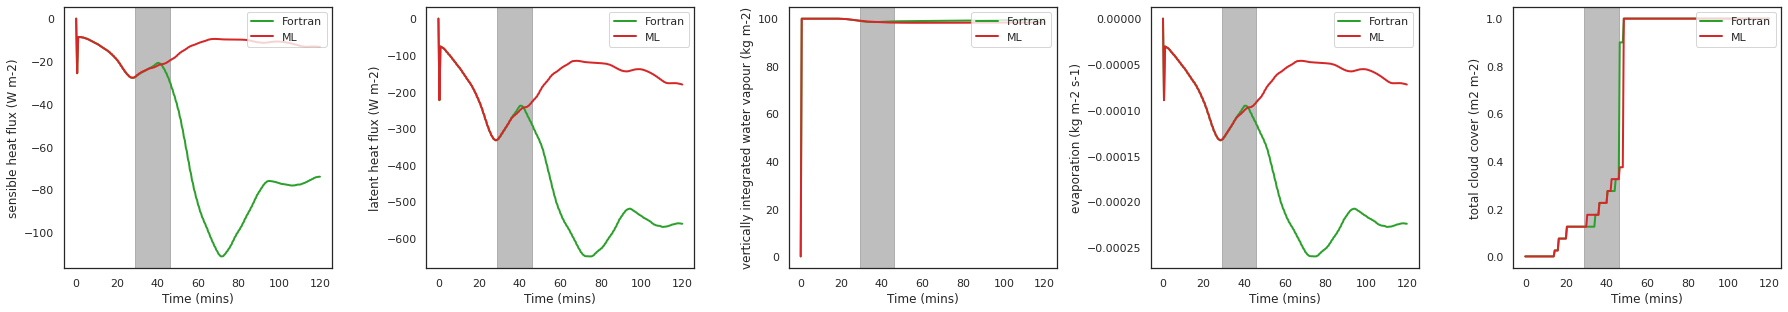

In [13]:
plot_temporal_profile(['hfss', 'hfls', 'prw', 'evspsbl', 'clt'])

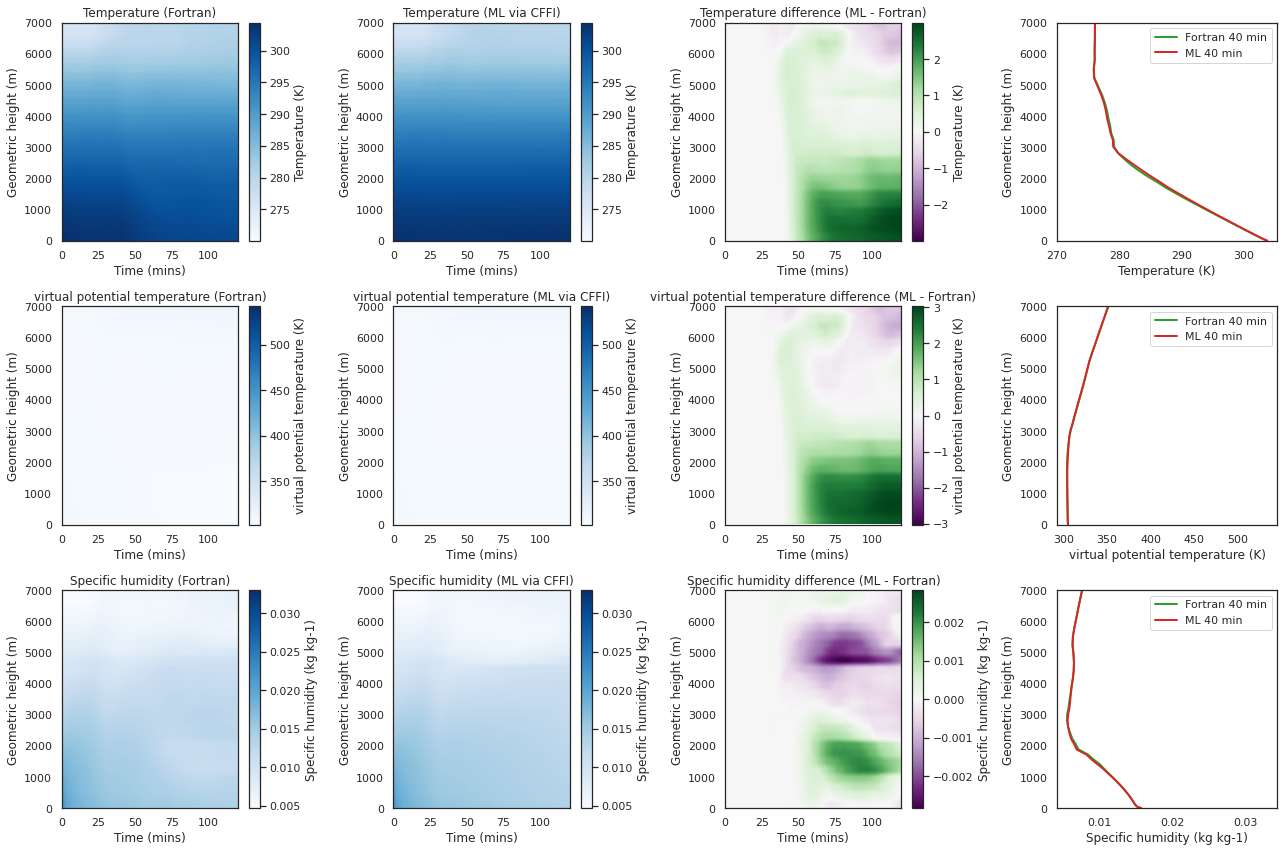

In [14]:
plot_vertical_profile(['ta', 'theta_v', 'hus'])

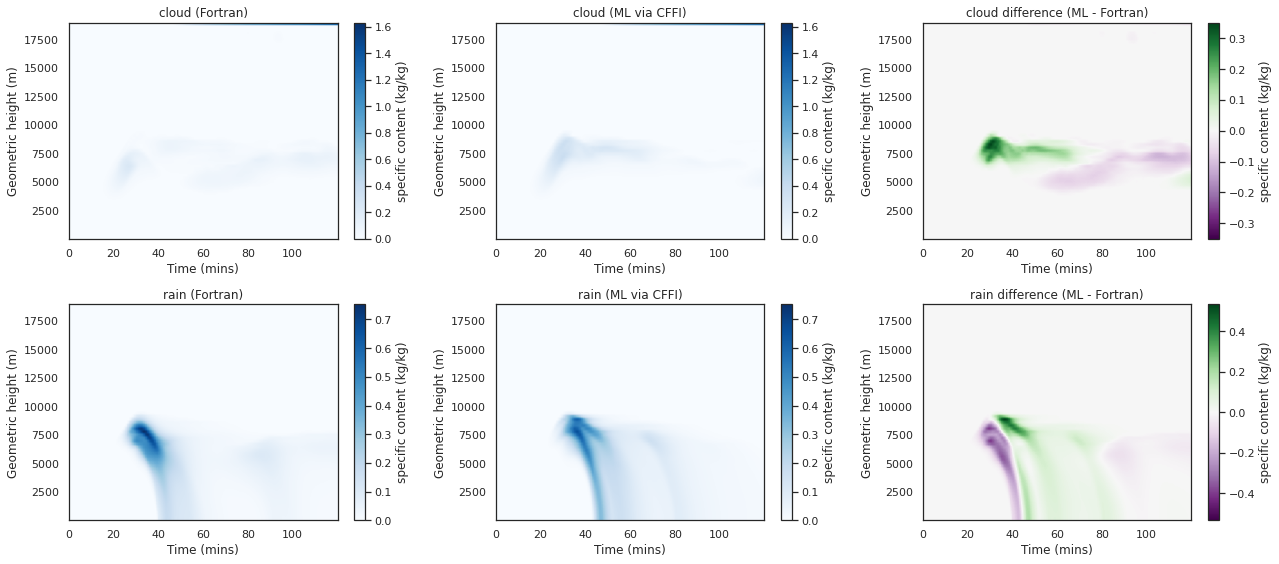

In [15]:
plot_height_profile(['cloud', 'rain'], cold=False, moment='specific_content')

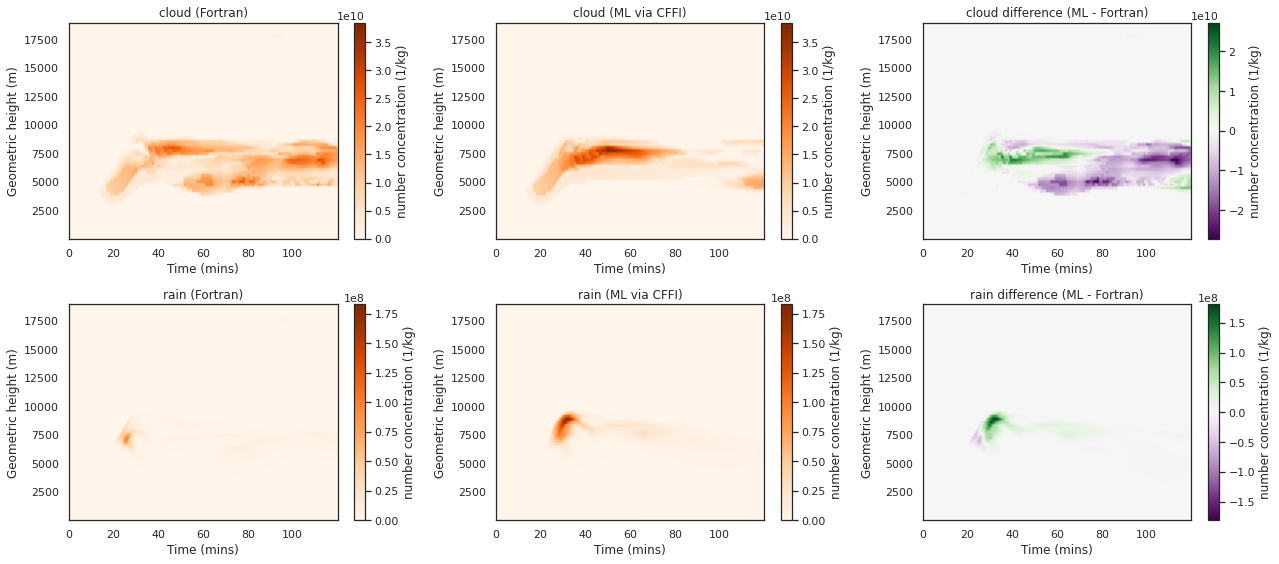

In [16]:
plot_height_profile(['cloud', 'rain'], cold=False, moment='number_concentration')